In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# The code below is needed for using Google Colab, so un comment this if that is what you're using 
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [4]:
import torch 
import numpy as np
import matplotlib.pyplot as plt


from nltk.tokenize import sent_tokenize 

from pathlib import Path 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.bpe import BPETokenizer 
from mingpt.utils import set_seed 
set_seed(1234)

In [5]:
import datasets
sst = datasets.load_dataset('glue','sst2', split="train[:1200]")

In [6]:
train, val = train_test_split(sst, test_size=0.2, stratify=sst["label"])

In [7]:
# print number of sentence pairs in train and validation
print(len(train['sentence']))
print(len(val['sentence']))

960
240


In [8]:
# check the distribution of labels in train and validation
array = np.array(train['label'])
unique, counts = np.unique(array, return_counts=True)
print(unique, counts)


array = np.array(val['label'])
unique, counts = np.unique(array, return_counts=True)
print(unique, counts)


[0 1] [435 525]
[0 1] [109 131]


In [9]:
class ModelData(Dataset):
    
    def __init__(self, sentence, label, truncation=-1):
    # Tokenize
        self.tokenizer = BPETokenizer()
        self.data = []  # List of 1-d pytorch tensor
        for sent in sentence:
            tokenized = self.tokenizer(sent).view(-1)  # pytorch tensor
            if truncation >= 0:
                self.data.append(tokenized[:truncation])
            else:
                self.data.append(tokenized)

        self.label = torch.tensor(label)

        # Count some items
        self.max_sentence_length = np.max([len(d) for d in self.data])

    def __len__(self):
        return len(self.data)

    def get_vocab_size(self):
        """
        We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer), 
        but actually, only a small number of vocab is used, especially for the small text. 
        """
        return 50257

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for 
        how the x and y are going to be used.
        """
        x = self.data[idx]
        y = self.label[idx]
        return (x, y)

    def get_block_size(self):
        """
        block_size is the size at which lines are truncated to ensure they are equal-length.
        """
        return self.max_sentence_length
    
# Instantiate the Training Dataset
train_dataset = ModelData(train['sentence'], train['label'], truncation=-1)

# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
val_dataset = ModelData(val['sentence'], val['label'], truncation=-1)

In [10]:
x,y = train_dataset[5]
print(x,y)
print("X: ",train_dataset.tokenizer.decode(x))
print("Y: ",y)

tensor([ 1018,   306,   355,   262,   427, 42457,  4875, 16223,   220]) tensor(0)
X:  ugly as the shabby digital photography 
Y:  tensor(0)


In [11]:
train_dataset.get_block_size()

52

In [12]:
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = 512
model_config.n_classification_class = 2
model = GPT(model_config)

number of parameters: 2.52M


In [13]:
modelsavename= "model_large.pt"

In [14]:
model.load_state_dict(torch.load(modelsavename))

<All keys matched successfully>

In [15]:
def lm_collate_fn(batch, device):
    x = [item[0] for item in batch]  # List (len B) of varying lengths
    y = [item[1] for item in batch]  # List (len B) of the same lengths as x
    maxlen = max([len(s) for s in x])

    padded_x, padded_y = [], []
    for sx, sy in zip(x, y):
        padded_x.append(torch.cat([sx, torch.ones(maxlen - len(sx))]))
        padded_y.append(sy)
    return torch.stack(padded_x).long().to(device), torch.stack(padded_y).long().to(device)

In [16]:
# Create a Trainer object and set the core hyper-parameters
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 1000  # For small corpus: 3000 iterations is plenty. For large corpus: 100000 iterations is needed
train_config.num_workers = 0
train_config.batch_size = 64    # For small corpus, batch size of 4 is fine.  For large corpus use 16
trainer = Trainer(train_config, model, train_dataset, val_dataset, collate_fn=lm_collate_fn, downstream_finetune=True)

running on device cuda


In [17]:
# This function is called at the end of every batch in training
# and is used to report the amount of time per 100 batches, and the loss at that point
train_loss, val_loss = [], []
train_acc, val_acc = [], []
def batch_end_callback(trainer):
  if trainer.iter_num % 100 == 0:
      print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
      # store the loss
      train_loss.append(trainer.loss.item())
      train_acc.append(trainer.train_acc.item())
trainer.set_callback('on_batch_end', batch_end_callback)

def val_batch_end_callback(trainer):
  if trainer.iter_num % 100 == 0:
      print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: val loss {trainer.val_loss.item():.5f}")
      # store the loss
      val_loss.append(trainer.val_loss.item())
      val_acc.append(trainer.val_acc.item())
trainer.set_callback('on_val_batch_end', val_batch_end_callback)

def train_end_callback(trainer):
    print('validation accuracy= ',trainer.final_acc.item()*100,'%')

trainer.set_callback('on_train_end', train_end_callback)

# Train!
trainer.run()

iter_dt 0.00ms; iter 0: train loss 1.31726
iter_dt 0.00ms; iter 0: val loss 0.75063
iter_dt 66.99ms; iter 100: train loss 0.91475
iter_dt 66.99ms; iter 100: val loss 0.74503
iter_dt 29.24ms; iter 200: train loss 0.82192
iter_dt 29.24ms; iter 200: val loss 0.75447
iter_dt 18.31ms; iter 300: train loss 0.71400
iter_dt 18.31ms; iter 300: val loss 0.67283
iter_dt 18.12ms; iter 400: train loss 0.59334
iter_dt 18.12ms; iter 400: val loss 0.74207
iter_dt 19.79ms; iter 500: train loss 0.52276
iter_dt 19.79ms; iter 500: val loss 0.78225
iter_dt 23.53ms; iter 600: train loss 0.36483
iter_dt 23.53ms; iter 600: val loss 0.77264
iter_dt 19.01ms; iter 700: train loss 0.17539
iter_dt 19.01ms; iter 700: val loss 0.84209
iter_dt 17.10ms; iter 800: train loss 0.27834
iter_dt 17.10ms; iter 800: val loss 0.98624
iter_dt 17.64ms; iter 900: train loss 0.19144
iter_dt 17.64ms; iter 900: val loss 1.44215
validation accuracy=  66.66666865348816 %


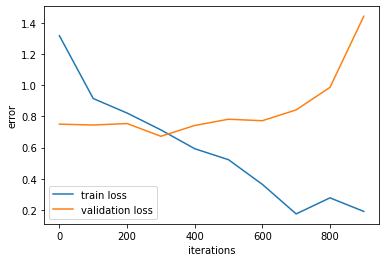

In [18]:
plt.plot(np.arange(len(train_loss))*100, train_loss, label='train loss')
plt.plot(np.arange(len(val_loss))*100, val_loss, label='validation loss')
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()

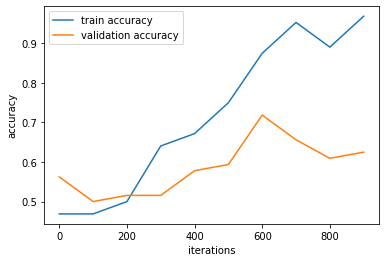

In [19]:
plt.plot(np.arange(len(train_acc))*100, train_acc, label='train accuracy')
plt.plot(np.arange(len(val_acc))*100, val_acc, label='validation accuracy')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.legend()
plt.show()